In [1]:
import numpy as np
import scipy
from scipy.stats import loguniform
from matplotlib import pyplot as plt
import emcee
import corner

# L11

1) Read in `solutions/transient.npy`. This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

In [2]:
data = np.load('transient.npy')
print(data.shape)

(100, 3)


In [3]:
error = np.int_(data[:,2])
t     = data[:,0]
flux  = data[:,1]

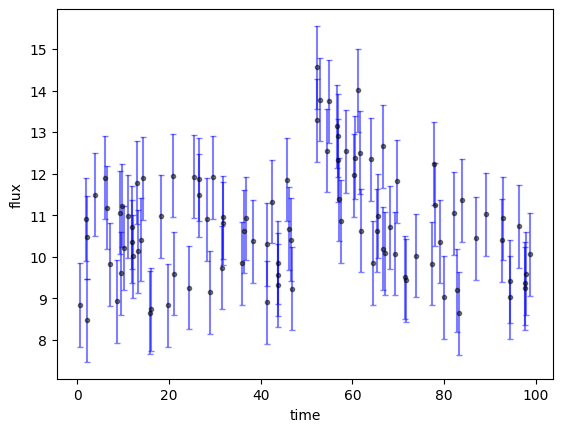

In [4]:
plt.errorbar(t, flux, yerr=error, fmt=".", capsize=2, color='black', ecolor='blue', alpha = 0.5)
plt.xlabel('time')
plt.ylabel('flux')
plt.show()

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

In [5]:
def model (p, t):
    b, A, t_0, alpha = p
    y = []
    for i in t:
        if (i<t_0):
            y.append(b)
        else:
            y.append(b + A*np.exp(-alpha*(i-t_0)))
    return y

def likelihood(p, error, t, flux):
    b, A, t_0, alpha = p
    # Gaussian likelihood
    return np.prod(np.exp(-(flux - model(p, t))**2 /2 /error**2))

def prior_uniform(x, interval):
    if (0<x<interval):
        return 1.0 / interval
    else:
        return 0
        
def prior_alpha(alpha):
    if np.exp(-5)<=alpha<=np.exp(5):
        return 1/alpha
    return 0
    
def posterior(p, error, t, flux):
    b, A, t_0, alpha = p
    return likelihood(p, error, t, flux)*prior_uniform(b,50)*prior_uniform(A,50)*prior_uniform(t_0,100)*prior_alpha(alpha)

def log_posterior(p, error, t, flux):
    
    log_p = np.log(posterior(p, error, t, flux))
    
    if not np.isfinite(log_p):
        return -np.inf
    else:
        return log_p

3) Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc3`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

In [6]:
ndim     = 4  # number of parameters in the model (b, A, t_0, alpha)
nwalkers = 10  # number of MCMC walkers
nsteps   = 10000  # number of MCMC steps to take **for each walker**

# uniform distribution centered in the naive values +- a variation for each walker
starting_guesses = np.array([10,5,50,0.1]) + np.random.random((nwalkers,ndim)) * 1e-2

# the function call to do the MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[error, t , flux])
sampler.run_mcmc(starting_guesses, nsteps, progress=True);

  1%|█                                                                                                                                                                      | 62/10000 [00:00<00:16, 616.73it/s]/tmp/ipykernel_23924/112620648.py:33: RuntimeWarning: divide by zero encountered in log
  log_p = np.log(posterior(p, error, t, flux))
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:14<00:00, 667.78it/s]


In [7]:
# throw-out the burn-in points and reshape:
tau = sampler.get_autocorr_time()
print('autocorrelation time = ', tau)
# tau is an estimation of the autocorrelation for each parameter
# this means that after 'tau' steps the chain forgets where it started
# it's a good guess then to burn some times this at the beginning
# "burn-in" period to let chains stabilize
burn = int(10*max(tau))
# thin by about half the autocorrelation time
thin = int(0.5*min(tau))
# then flat all the chain to have a flat list of samples
flat_samples = sampler.get_chain(discard=burn, thin=thin, flat=True)
print('original shape: ', sampler.chain.shape) #original chain shape (#walkers, #steps, #parameters)
print('burned, thinned, and flatten shape: ', flat_samples.shape)  #burned, thinned, and flattened chain

autocorrelation time =  [68.58460289 83.10048749 93.2876476  67.06188137]
original shape:  (10, 10000, 4)
burned, thinned, and flatten shape:  (2740, 4)


Text(0.5, 0, 'step number')

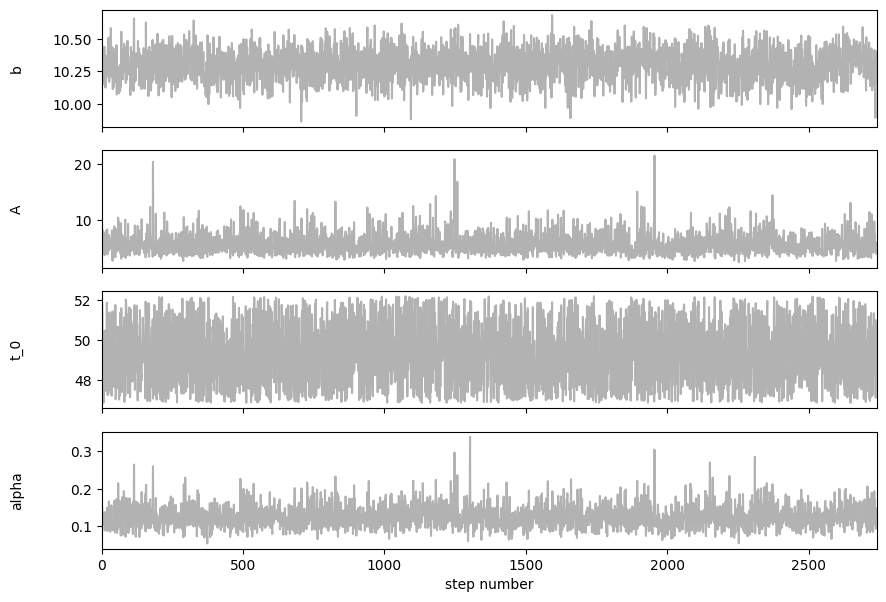

In [8]:
# I want to plot the trace to check if everything is alright
# examples: before I was doing something wrong and the traces were flat
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
labels = ['b', 'A', 't_0', 'alpha']
for i in range(ndim):
    ax = axes[i]
    ax.plot(flat_samples[:, i], 'k', alpha=0.3)
    ax.set_xlim(0, len(flat_samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

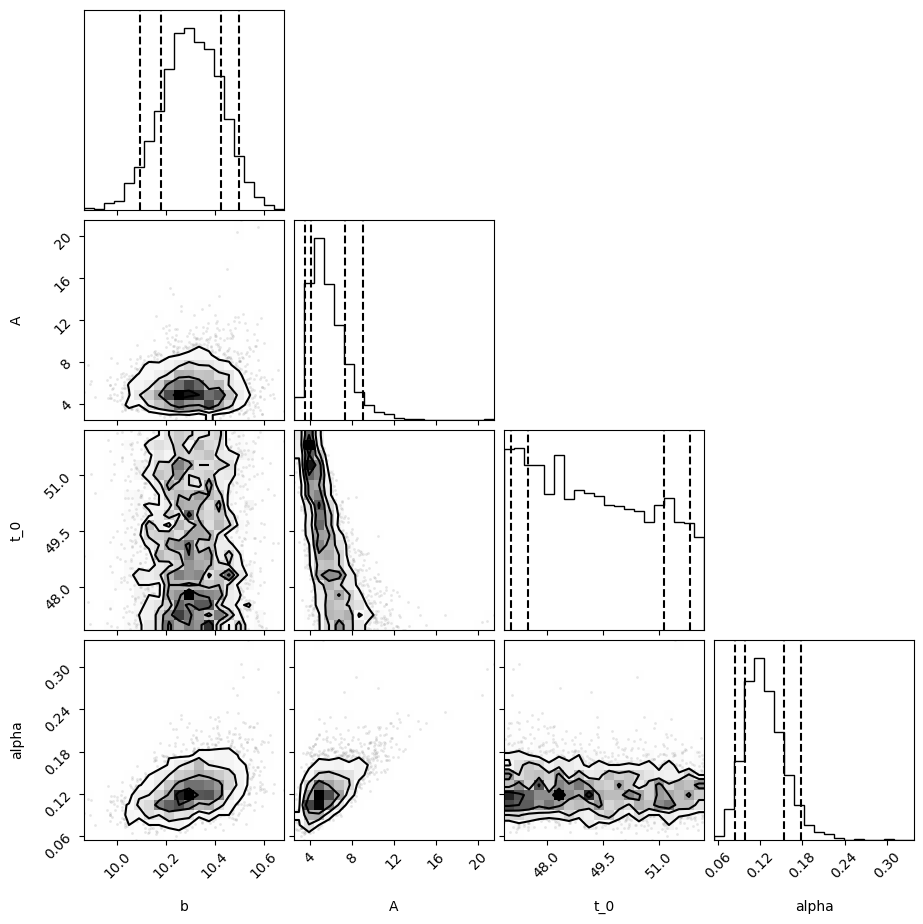

In [9]:
fig = corner.corner( flat_samples, labels=labels, quantiles=[0.05, 0.95, 0.16, 0.84] )

# for a 'zoom-out':

#fig.axes[4].set_ylim(0,15)
#fig.axes[8].set_ylim(45,54)
#fig.axes[9].set_xlim(0,16)
#fig.axes[9].set_ylim(45,54)
#fig.axes[12].set_ylim(0.03,0.26)
#fig.axes[13].set_xlim(0,16)
#fig.axes[14].set_xlim(45,54)

Some considerations on this corner plot:
- it seems that the bakground (b) is not correlated a lot with the other parameters.
- there seems to exist a correlation between **A** and **t_0**. For high t_0 I have low A and vice-versa.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

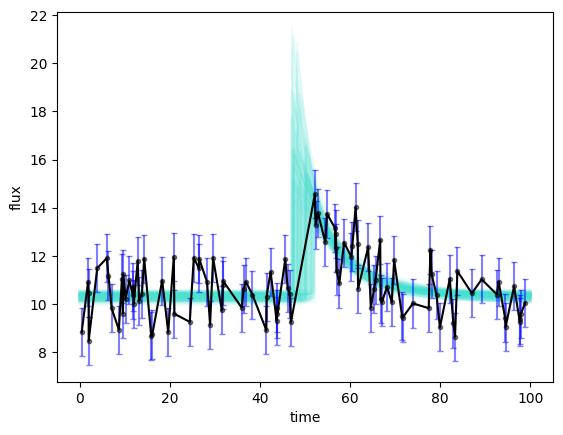

In [10]:
x0 = np.linspace(0,100,1000)

inds = np.random.randint(len(flat_samples), size=100)

for ind in inds:
    
    sample = flat_samples[ind]
    plt.plot(x0, model(sample,x0), 'turquoise', alpha=0.1)
    
plt.errorbar(t, flux, yerr=error, fmt=".", capsize=2, color='black', ecolor='blue', alpha = 0.5)
plt.plot(t, flux, 'k')

plt.xlabel('time')
plt.ylabel('flux');

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 

In [11]:
param_ = []
for i,l in enumerate(labels):
    median  = np.median(flat_samples[:,i]) # RB the median is the 50th percentile
    param_.append(median)
    p5, p95 = np.percentile(flat_samples[:,i], [5,95])
    print(l+':  ', round(median,3), '  +', round(p95-median,3), '  -', round(median-p5,3))

b:   10.303   + 0.196   - 0.209
A:   5.357   + 3.681   - 1.813
t_0:   49.143   + 2.666   - 2.078
alpha:   0.123   + 0.056   - 0.038


In [12]:
param_

[10.303414300219728, 5.356646407487204, 49.14264968948149, 0.12304548108578506]

useful thing: https://emcee.readthedocs.io/en/stable/tutorials/line/

# L12


In [13]:
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils    as dyfunc

Let's go back to our previous example on the astrophysical transient.

8) Fit the same model from before with the same priors,  but this time use nested sampling.

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

From dynesty crash course: <br>
**dynesty** requires three basic ingredients to sample from a given distribution:
- the likelihood (via a loglikelihood() function, evaluates the likelihood of the observed data given the parameters)
- the prior (via a prior_transform() function that transform samples from the unit cube to the target prior, samples from a unit cube (where all values are between 0 and 1) to the parameter space defined by the prior distribution)
- the dimensionality of the parameter space (the number of parameters you are estimating).

In [14]:
# always a gaussian likelihood, but now I need it in log for dynasty
# remember that I have a likelihood for each point, and then I have tot ake the product for all of them
# since its a log, I need to sum them instead
def loglikelihood(p, error, t, flux):
    b, A, t_0, alpha = p
    return np.sum(np.log((1/((2*np.pi)**(1/2)*error)))) + np.sum(-(flux - model(p, t))**2 / 2 /error**2)

In [15]:
# I need to change the priors to one of a hypercube
# dynesty proveds a transformation that maps uniform samples to my desired prior distribution.
# this allows to handle arbitrary prior shapes and ranges by transforming unit-cube samples.
# u will be a value from a uniform distribution [0,1]

def prior_transform(u):
    b   = u[0] * 50
    A   = u[1] * 50
    t_0 = u[2] * 100
    # since log alpha should be between -5 and +5
    alpha = scipy.stats.loguniform.ppf(u[3],np.exp(-5),np.exp(+5))
    
    return np.array([b, A, t_0, alpha])

In [16]:
# I have 4 parameters
dimension = 4

Now, I use dynesty

In [17]:
# Initialize the sampler
# Live points = samples that are being evolved throughout the nested sampling process.
# not too much because of the high computational cost, not too few because of low accuracy
# logl_args are the additional arguments needed to compute the likelihood
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, dimension, nlive=1000, logl_args=(error, t, flux))

# execute Nested Sampling
sampler.run_nested()

8006it [01:06, 24.21it/s, bound: 62 | nc: 492 | ncall: 128342 | eff(%):  6.238 | loglstar:   -inf < -178.404 <    inf | logz: -185.312 +/-  0.076 | dlogz: 35.676 >  1.009]   /home/elenasofiamangola/.local/lib/python3.10/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
/home/elenasofiamangola/.local/lib/python3.10/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may c

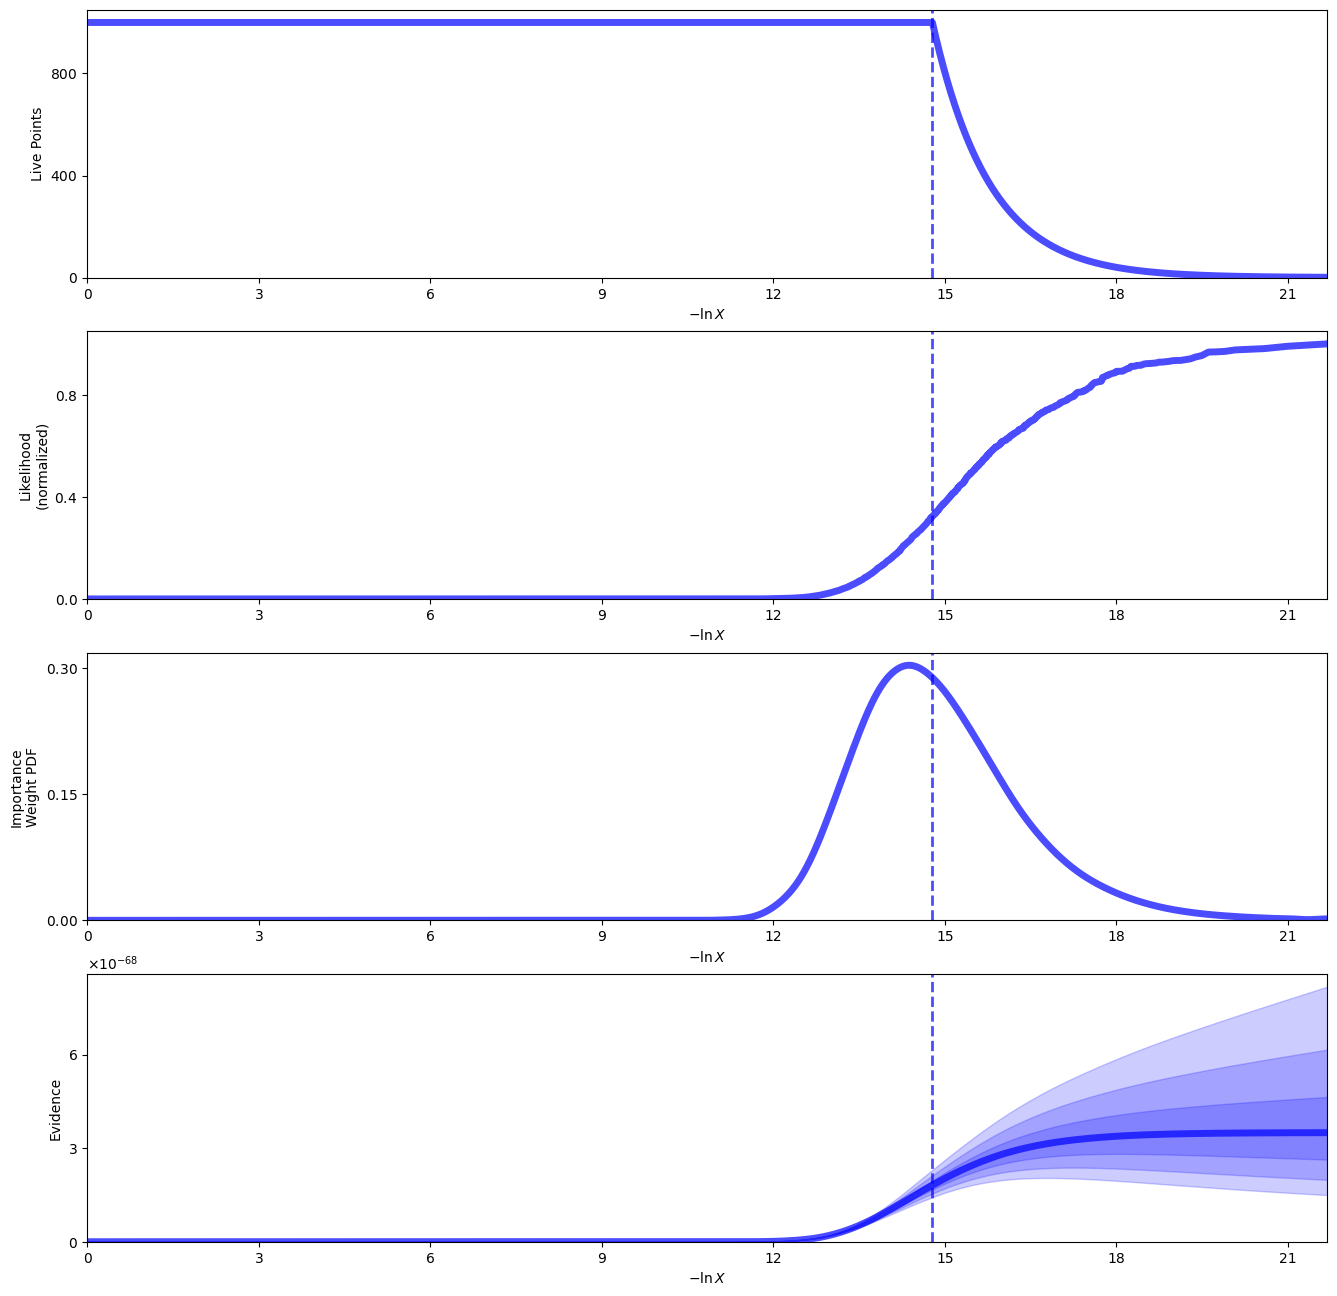

In [18]:
# Plot a summary of the run.
results     = sampler.results
rfig, raxes = dyplot.runplot(results)
# X is the fraction of prior volume remaining, as -lnX increases, we explore more high-density regions
# dashed line = the sampling process has reached convergence
# plot 1: number live points is constant, but every points is updated with a one with an higher likelihood as we go along.
#         They decrease as the evidence estimate has been stabilized.
# plot 2: the sampler explores regions of high likelihood values with passing time. So, it's very good, I'm going to regions of high density posterior.
# plot 3: weights (L_i*delta_X_i= relative importance of each sample to the total evidence) start is flat -> each sample contributes in the same manner
#         it goes up-> the likelihood increases, it goes to regions that contribute more to the final evidence
#         it goes down again -> likelihood still high, but prior volume X is really small, it's converging
#         NB if it doesn't go down it's because I don't have enogh exploration -> solution: increase number of live points to explore better
# plot 4: evidence (= marginal likelihood), it increases because it is being accumulated over time. When I have the plateau it's beacuse I reached convergence.
#         having more sampling wouldn't change the result.
#         The shaded part are 1,2,3 sigma errors

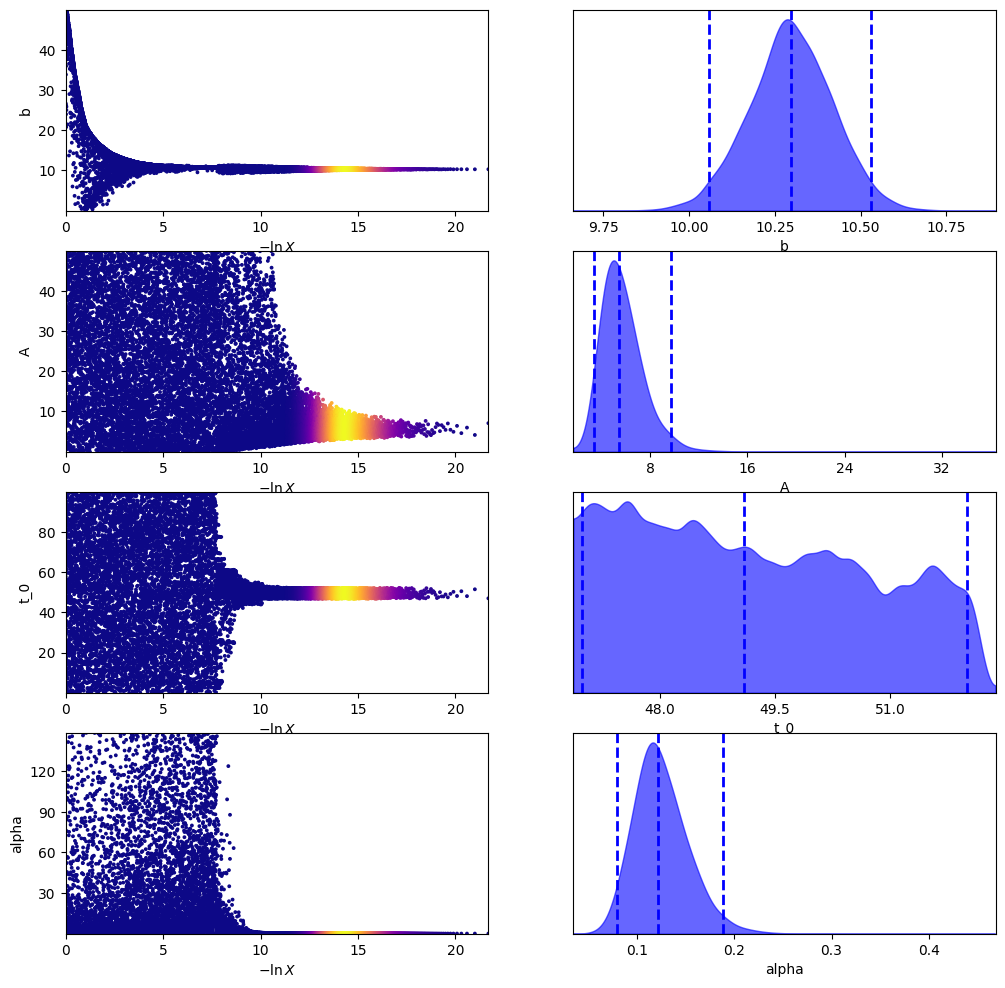

In [19]:
tfig, taxes = dyplot.traceplot(results,labels=['b', 'A', 't_0', 'alpha'])
# left:  trace plots, live points vs iteration. Show how they go around the parameters space.
# yellow is when it converged
# right: marginal distributions of sampled parameters values.

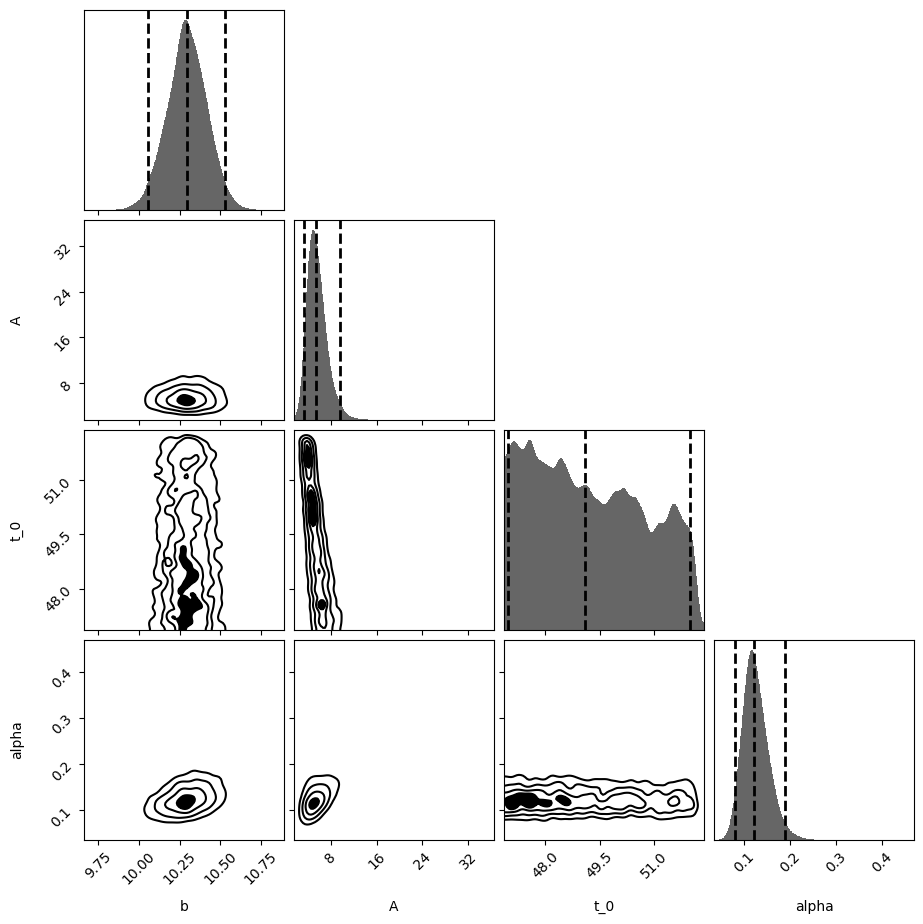

In [20]:
cfig, caxes = dyplot.cornerplot(results,labels=['b', 'A', 't_0', 'alpha'])

The corner plots are similar to the ones with MCMC! It's good :)

In [32]:
# without weights, the samples would not reflect the true posterior distribution accurately
samples = results.samples
# normalized weight
weights = np.exp(results.logwt - results.logz[-1])
# compute quantiles
quantiles =[dyfunc.quantile(samps, [0.05,0.5,0.95], weights= weights) for samps in samples.T] #.T so every row is a parameter
for q,l in zip(quantiles,(labels)):
    p5, median, p95 = q
    print(l+':  ', round(median,3), '  +', round(p95-median,3), '  -', round(median-p5,3))
median = np.array(quantiles)[:,1]

b:   10.296   + 0.198   - 0.202
A:   5.432   + 3.389   - 1.822
t_0:   49.096   + 2.729   - 2.012
alpha:   0.122   + 0.053   - 0.036


9) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

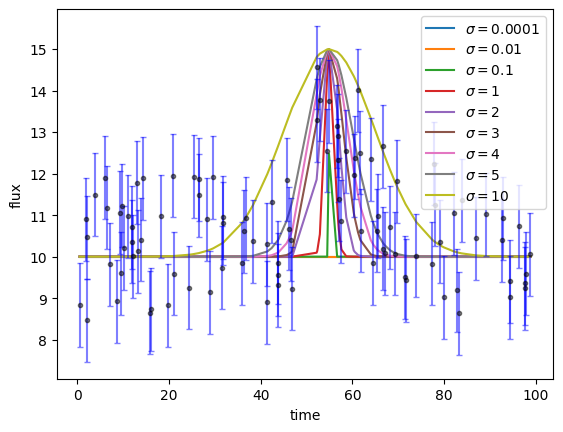

In [22]:
#fit the data with the gaussian model to find a reasonable prior on sigma

def model_G (p, t):
    b, A, t_0, sigma_w = p
    y = (b + A*np.exp(-(t-t_0)**2/(2*sigma_w**2)))
    return y

b, A, t_0 = 10, 5, 55
sigmas = [0.0001,0.01,0.1,1,2,3,4,5,10]
model_gauss = []
for i, s in enumerate(sigmas):
    par = [b, A, t_0, s]
    model_gauss.append(model_G(par, t))
    plt.plot(t, model_gauss[i], label= r'$\sigma =$'+str(s))

plt.errorbar(t, flux, yerr=error, fmt=".", capsize=2, color='black', ecolor='blue', alpha = 0.5)
#plt.plot(t, flux, 'k')
plt.legend()
plt.xlabel('time')
plt.ylabel('flux');

Let's do something between $0.1$ and $10$.

In [23]:
def loglikelihood_G(p, error, t, flux):
    return np.sum(np.log((1/((2*np.pi)**(1/2)*error)))) + np.sum(-(flux - model_G(p, t))**2 / 2 /error**2)

def prior_transform_G(u):
    b   = u[0] * 50
    A   = u[1] * 50
    t_0 = u[2] * 100
    sigma_w = scipy.stats.loguniform.ppf(u[3],0.1,10)
    
    return np.array([b, A, t_0, sigma_w])

In [24]:
# Same things as before
sampler_G = dynesty.NestedSampler(loglikelihood_G, prior_transform_G, dimension, nlive=10000, logl_args=(error, t, flux))
sampler_G.run_nested()
# .results retrieve results like :log-evidence (logz), posterior samples (samples), weights (logwt)
results_G = sampler_G.results

117785it [08:50, 222.11it/s, +10000 | bound: 68 | nc: 1 | ncall: 1384324 | eff(%):  9.298 | loglstar:   -inf < -144.449 <    inf | logz: -159.885 +/-  0.127 | dlogz:  0.004 > 10.009]


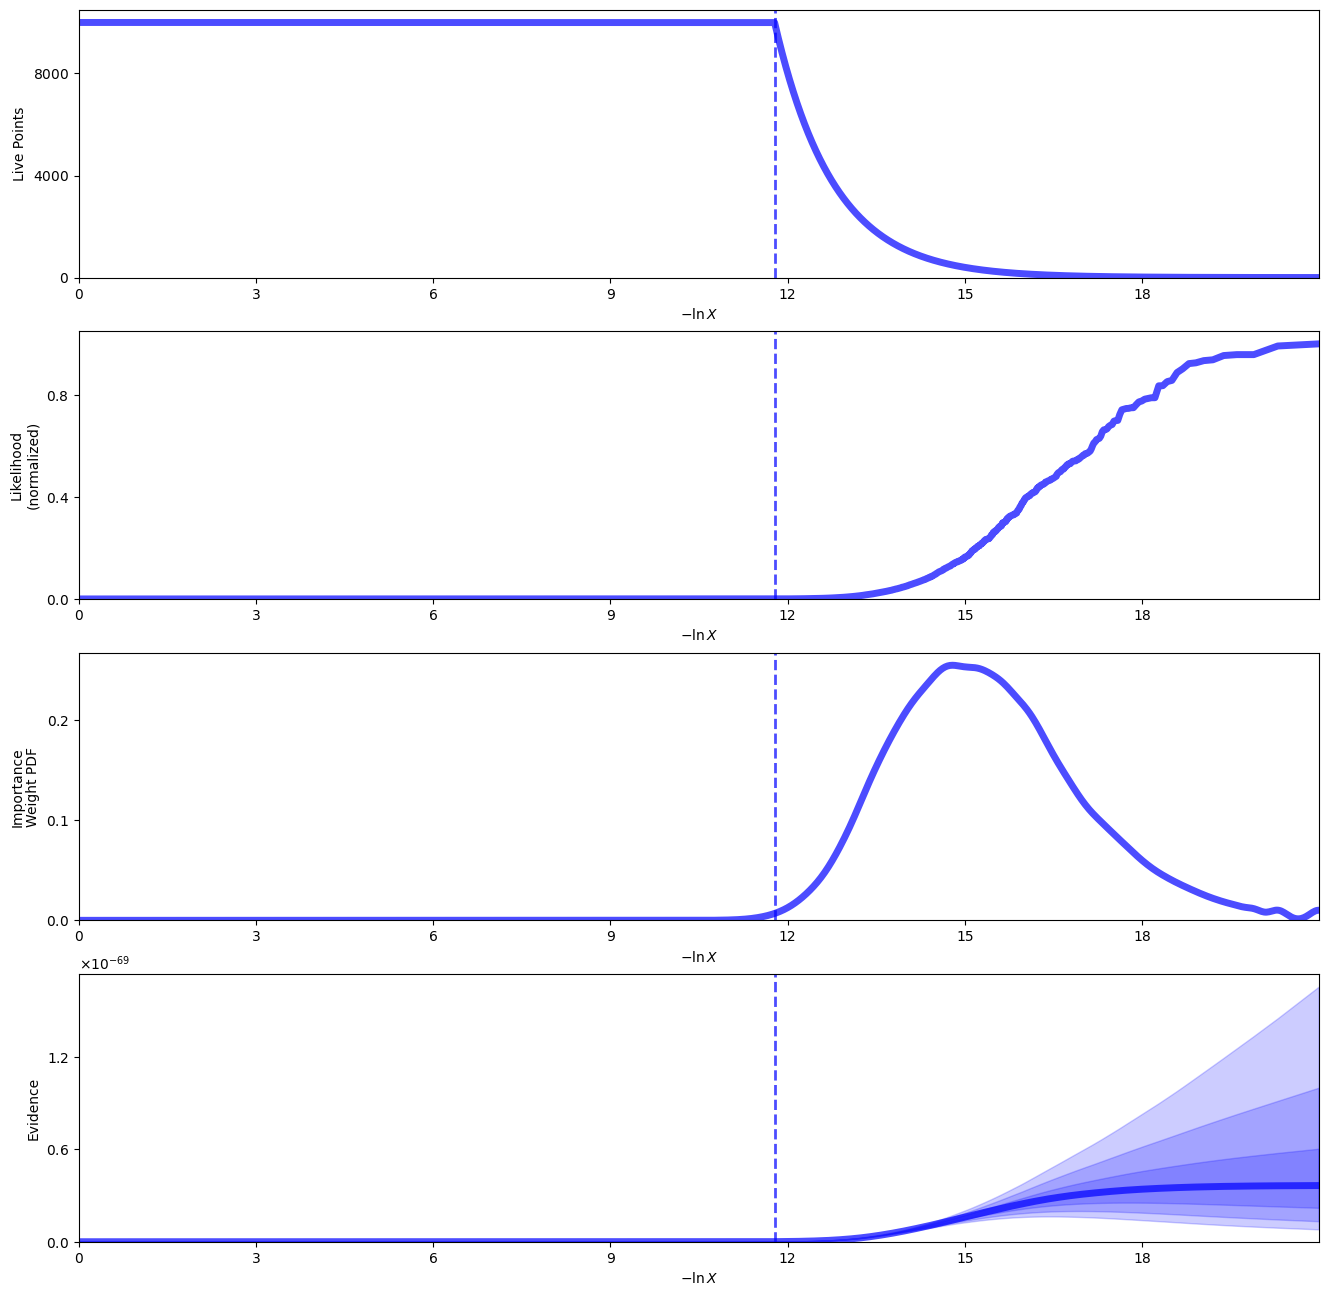

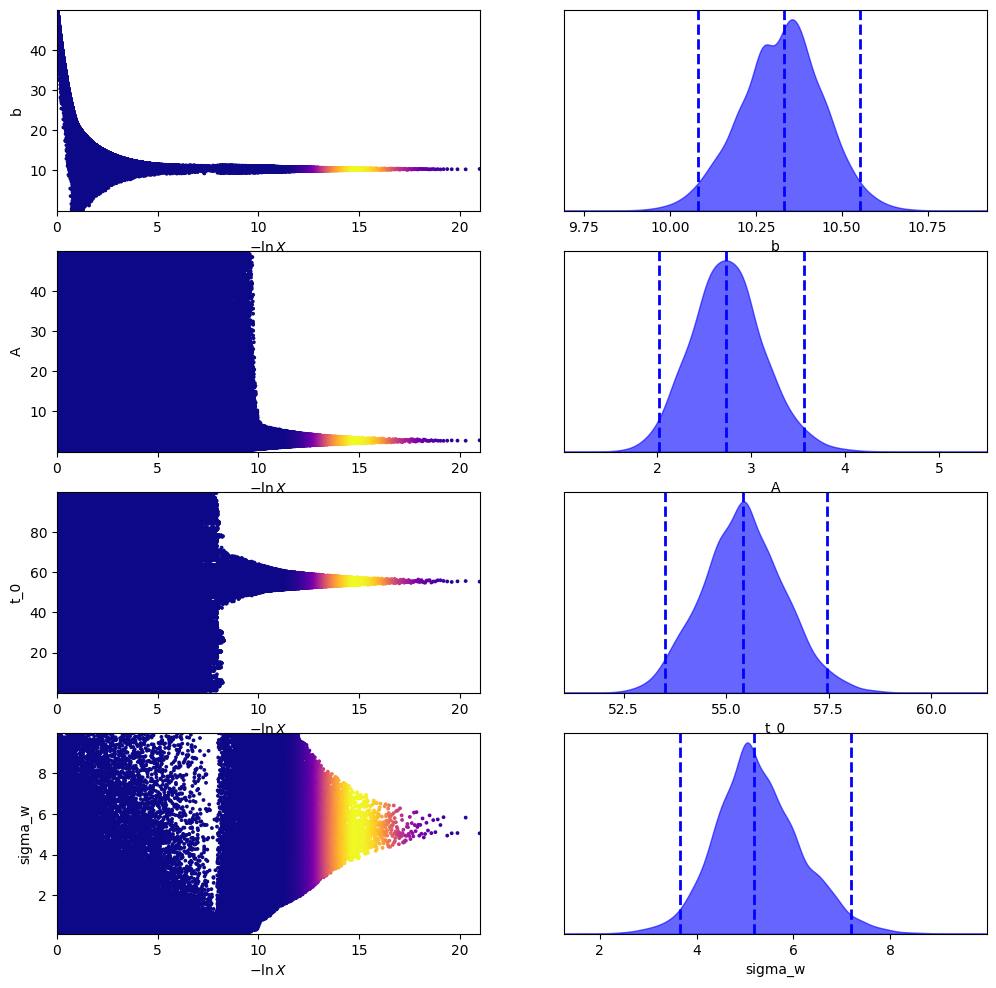

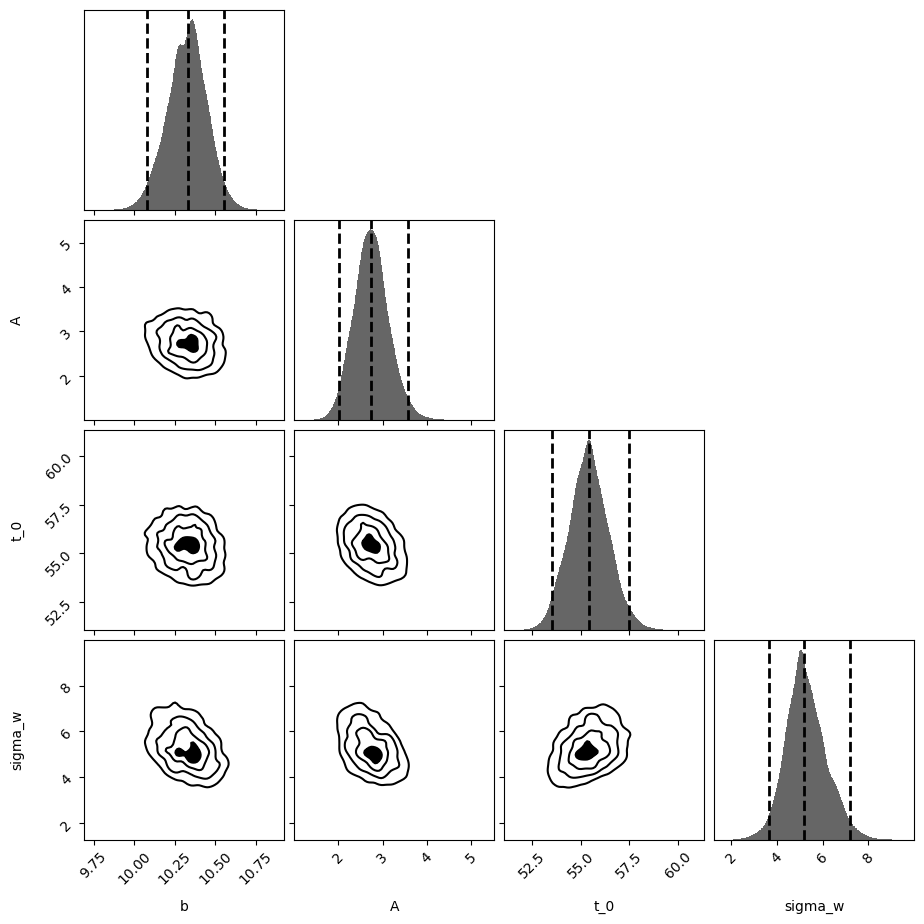

In [25]:
rfig, raxes = dyplot.runplot(results_G)
tfig, taxes = dyplot.traceplot(results_G,labels=['b', 'A', 't_0', 'sigma_w'])
cfig, caxes = dyplot.cornerplot(results_G,labels=['b', 'A', 't_0', 'sigma_w'])

10) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data?

In [26]:
# Print out the log-evidence (marginal likelihood)
print("Log-evidence for brust model:", results.logz[-1], ' +- ', results.logzerr[-1])
print("Log-evidence for Gaussian model:", results_G.logz[-1], ' +- ', results_G.logzerr[-1])

Log-evidence for brust model: -155.3244221115061  +-  0.2832462776331158
Log-evidence for Gaussian model: -159.88524039954854  +-  0.504428930945019


In [27]:
print('Ratio between Evidence1 and Evidence2 = ', np.exp(results.logz[-1])/np.exp(results_G.logz[-1]))

Ratio between Evidence1 and Evidence2 =  95.661726658522


Since the ratio is higher than $1$, the favourite model is the brust one.

In [28]:
# without weights, the samples would not reflect the true posterior distribution accurately
samples_G = results_G.samples
# normalized weight
weights_G = np.exp(results_G.logwt - results_G.logz[-1])
# compute quantiles
quantiles_G =[dyfunc.quantile(samps, [0.05,0.5,0.95], weights= weights_G) for samps in samples_G.T] #.T so every row is a parameter
for q,l in zip(quantiles_G,(labels)):
    p5, median, p95 = q
    print(l+':  ', round(median,3), '  +', round(p95-median,3), '  -', round(median-p5,3))
median_G = np.array(quantiles_G)[:,1]

b:   10.333   + 0.183   - 0.211
A:   2.737   + 0.68   - 0.596
t_0:   55.4   + 1.702   - 1.635
alpha:   5.185   + 1.646   - 1.248


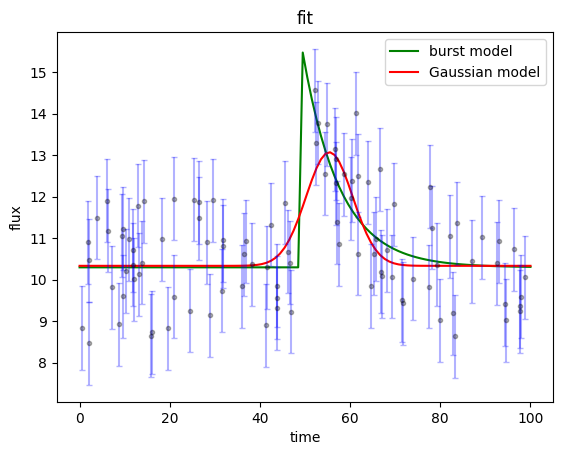

In [34]:
x0 = np.linspace(0,100,100)
y_G=np.array([model_G(median_G, x) for x in x0])
y  =np.array([model(median, [x]) for x in x0])
plt.plot(x0,y ,color='green',label='burst model')
plt.plot(x0,y_G, color='red',label='Gaussian model')
plt.errorbar(t, flux, yerr=error, fmt=".", capsize=2, color='black', ecolor='blue', alpha = 0.3)
plt.legend()
plt.title('fit')
plt.xlabel('time')
plt.ylabel('flux')
plt.show()